this is for all the awards

1. synth timeseries - done
2. synth tpfs via convolution on subpixel - done
3. fit with gaussian only on the first frame - done
4. fit with zernikes only on the first frame
5. look at coherence


In [425]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from scipy.signal import convolve2d
from skimage.transform import rescale
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [426]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
prf = eleanor.prf.make_prf_from_source(star)

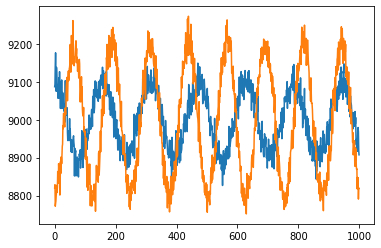

In [428]:
# make some synth data
# i want it to be a transit later so that I can get a CDPP
# but just for method validation let's use a sine wave
amps = 100 * np.array([1, 2])
freqs = np.array([0.04, 0.05])
phis = np.pi * np.array([1, 3]) / 2
t = np.arange(0, 1000)
lc = 9000 + np.vstack((a * np.sin(f * t + p) for a, f, p in zip(amps, freqs, phis)))
lc_m = lc + np.random.normal(0, 25, lc.shape)
plt.plot(t, lc_m.T)

In [511]:
xc, yc = [6.1, 8.2], [6.8, 8.1]
tpfs_up = np.zeros((len(lc_m.T), 99, 99))

base_tpfs = [np.zeros((99,99)) for _ in range(len(xc))] # 11x11 pixels times 9 subpixels
for (xc_v, yc_v, base_v, fl) in zip(xc, yc, base_tpfs, lc_m):
    xl, xu = int(np.floor(xc_v * 9)), int(np.ceil(xc_v * 9)) 
    yl, yu = int(np.floor(yc_v * 9)), int(np.ceil(yc_v * 9))
    for (x, y) in [(xl, yl), (xu, yl), (xl, yu), (xu, yu)]:
        base_v[x, y] += (1 - abs(x - 9 * xc_v)) * (1 - abs(y - 9 * yc_v))
    base_v = convolve2d(base_v, prf)[58:-58, 58:-58]
    base_up = np.array([base_v * f for f in fl])
    tpfs_up += base_up


In [512]:
tpfs = 160 + np.array([rescale(tpf_up.T, 1/9) for tpf_up in tpfs_up])
errs = 25 * np.ones_like(tpfs)

In [513]:
tpfs_t, errs_t = torch.tensor(tpfs), torch.tensor(errs)

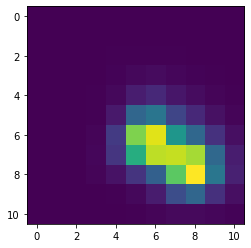

In [514]:
plt.imshow(tpfs_t[900])

In [515]:
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - tpfs_t[i]) ** 2, errs_t[i]))

In [755]:
model = eleanor.models.Gaussian(
            shape=tpfs.shape[1:], 
            col_ref=0, 
            row_ref=0,
            xc = xc,
            yc = yc,
            bkg0 = 90,
            loss = nll
        )

nstars = len(xc)
pars = model.get_default_par(tpfs[0])
num_psf_pars = len(model.get_default_optpars())
fout = np.zeros((len(tpfs), nstars))
bkgout = np.zeros(len(tpfs))
llout = np.zeros(len(tpfs))
parsout = np.zeros((len(tpfs), num_psf_pars))

def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

[autoreload of eleanor.models failed: Traceback (most recent call last):
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 276, in update_instances
    refs = gc.get_referrers(old)
K

In [ ]:
pars

In [ ]:
loss_and_grad_fn(pars, 0)

In [ ]:
for i in tqdm.trange(10):
    res = sopt.minimize(loss_and_grad_fn, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x

print(res)

In [ ]:
prf_pars = np.array([ 1.32345295e-01, -2.64309959e-03, -1.87840080e-03, -4.65669288e-02, 5.62057525e-03, -4.09518654e-03, -1.86680846e-04, 1.28241834e-03, 1.11773300e-04, 7.87455055e-04, 5.40537843e-03, 1.51009769e-03, -1.38667853e-03,  5.29446498e-04, -5.14992295e-04])

In [922]:
import eleanor
#xc, yc = np.array([4.51646021, 4.3177313 , 4.10392764]), np.array([6.52438976, 2.51141035, 3.87952034])
zmodel = eleanor.models.Zernike(
    shape=tpfs.shape[1:], 
    col_ref=0, 
    row_ref=0, 
    xc = xc,
    yc = yc,
    bkg0 = 90,
    loss = nll,
    source = star,
    zern_n=6
)

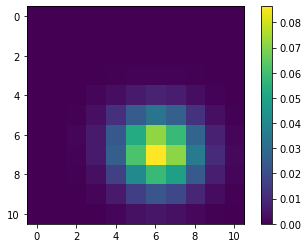

In [923]:
plt.imshow(zmodel(1, 0, 0, zmodel.get_default_optpars(), 0))
plt.colorbar()

In [924]:
nstars = 2
pars = model.get_default_par(tpfs[0])
num_psf_pars = len(model.get_default_optpars())
fout = np.zeros((len(tpfs), nstars))
bkgout = np.zeros(len(tpfs))
llout = np.zeros(len(tpfs))
parsout = np.zeros((len(tpfs), num_psf_pars))

def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = zmodel.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [925]:
p0 = zmodel.get_default_par(np.max(tpfs[0]))

In [926]:
p0

array([ 1.56741061e+03,  1.56741061e+03,  0.00000000e+00,  0.00000000e+00,
        9.00000000e+01,  5.00000000e-01,  1.09184332e-01, -1.45205934e-03,
       -2.84481957e-03, -5.27177534e-02,  4.16214831e-03, -2.87880837e-03,
       -9.43701418e-04,  2.23552375e-03,  1.50715429e-04,  1.06101866e-03,
        1.28122959e-02,  2.62769921e-03, -4.90537634e-03, -1.90283084e-04,
       -9.72907680e-04, -3.86303301e-04,  2.75168351e-04, -2.05992081e-04,
        1.12589931e-03, -2.36696560e-04,  1.48563323e-04, -2.05164856e-03,
        1.87304886e-03, -1.04975452e-03,  5.19002101e-04,  2.40511476e-04,
        1.51873374e-05, -1.13042640e-04])

In [927]:
loss_and_grad_fn(p0, 0)

(array(550567.92387658),
 array([-5.54883126e+01, -4.19518588e+01,  3.21562857e+03,  1.59511277e+04,
        -1.83335539e+03, -1.95029693e+05,  3.92414135e+04,  7.70591594e+04,
        -1.01161511e+05,  8.05844252e+04, -1.23518565e+05, -8.73644194e+04,
         1.13512541e+04,  2.80891330e+03,  5.19899379e+05, -3.79269164e+04,
         4.49489782e+03, -1.03488559e+04,  3.91857954e+03, -5.45198079e+02,
        -1.50655230e+04,  7.35456038e+02,  7.33967935e+02, -1.23062853e+03,
        -5.24154851e+03, -3.82774560e+02, -4.39368801e+02,  1.91980441e+03,
        -1.45892389e+02, -9.68628846e+02, -1.49285448e+03,  3.78252485e+02,
         8.30289896e+01, -3.11459607e+03]))

In [928]:
pars = p0
lc_z = np.zeros(1000)
for i in tqdm.trange(10):
    res = sopt.minimize(loss_and_grad_fn, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x
    lc_z[i] = pars[0]

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


In [929]:
res

     fun: array(254.49965357)
     jac: array([ 9.59302888e-05,  9.59147955e-05,  7.71794971e-02,  1.97184284e-01,
       -1.73503188e-03, -3.16920647e-01, -1.15903900e-01,  1.26502157e-01,
       -5.82858311e-02,  6.84760541e-01,  1.14293278e+00, -4.07380599e+00,
        1.01108386e-01, -2.38708285e-01,  1.93415831e+01,  5.51444712e-01,
        1.37255253e-02,  1.52682979e+00, -6.28821712e-04, -1.94462449e-01,
       -1.13634168e+00,  1.06740286e-01,  2.91258297e-03, -9.60142866e-02,
       -9.87475399e-02,  1.83419672e-02, -7.18848079e-02,  1.29821385e-02,
        1.89387985e-02, -1.05386643e-01,  2.79248406e-01, -2.10976164e-02,
       -5.27367969e-05,  1.98447014e-01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 55
     nit: 6
  status: 1
 success: True
       x: array([ 8.05165352e+03,  9.08899589e+03, -3.95949271e-01, -6.52021105e-01,
        1.63674444e+02,  7.48560832e-01, -1.75351090e-01,  2.98958272e-02,
        9.02684294e-02, -6.54051840e-01, -2.36607603e-02,  9.36

In [906]:
lc_m[:,9]

array([9089.07789845, 8821.51217508])

In [413]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
true_tpfs = torch.tensor(sc.flux[sq][start:end].astype(np.float32).value)

In [414]:
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - true_tpfs[i]) ** 2, torch.tensor(errs_t)[i]))
def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = zmodel.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [416]:
sopt.minimize(loss_and_grad_fn, p0, 100, jac=True, method='TNC', tol=1e-4)

     fun: array(21265863.87635747)
     jac: array([ 3.92494266e+01, -3.81091381e+05, -1.16955152e+06,  1.06762627e+03,
        5.11817840e+07,  1.40453592e+08,  1.14300077e+08, -4.40546287e+04,
       -1.15055764e+04, -1.36692696e+05, -5.12737339e+04, -1.01031549e+05,
       -1.18997308e+05, -8.47806960e+04, -1.08430107e+05, -3.81395474e+05,
       -1.74649652e+05, -8.09259811e+04, -5.18423673e+04, -1.03430234e+05,
       -1.01630920e+05,  1.47599642e+05])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 215
     nit: 24
  status: 2
 success: True
       x: array([ 5.77221804e+03,  1.57271975e+00,  1.01475542e+00,  1.14285457e+03,
        2.39274159e-01, -1.50454955e-01,  6.84729644e-02,  5.06394645e+01,
       -1.21379890e+00,  2.56097730e+00, -3.95893629e+01,  1.13777337e+00,
        3.78079847e+00, -3.32584698e+00,  1.86895659e+00, -9.82978613e-01,
       -1.08791228e+00, -8.46685807e+01,  5.74550050e-01,  3.75098885e+00,
        2.33183375e+00,  5.54238457e-01])